# Подключение модулей

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [41]:
db = pd.read_csv("netflix_titles.csv")

In [42]:
db.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


#### Разбор данных
- show_id — Уникальный идентификатор (ID) фильма или сериала в каталоге Netflix.

- type — Тип контента: фильм («Movie») или сериал («TV Show»).

- title — Название фильма или сериала.

- director — Имя режиссёра (если указано).

- cast — Список актёров, занятых в проекте.

- country — Страна производства.

- date_added — Дата добавления контента в библиотеку Netflix.

- release_year — Год выхода (премьеры).

- rating — Возрастной рейтинг (например, PG-13, TV-MA).

- duration — Продолжительность (для фильмов — в минутах, для сериалов — количество сезонов).

- listed_in — Жанр или категория, к которой относится контент.

- description — Краткое описание сюжета.

In [43]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [44]:
db.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


In [45]:
db.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [46]:
missing_data = db.isnull().sum()
missing_percentage = (missing_data / len(db)) * 100
missing_df = pd.DataFrame({'Пропущено': missing_data, 
                          'Процент': missing_percentage})
print("Пропущенные значения:")
print(missing_df[missing_df['Пропущено'] > 0])

Пропущенные значения:
            Пропущено    Процент
director         2634  29.908028
cast              825   9.367549
country           831   9.435676
date_added         10   0.113546
rating              4   0.045418
duration            3   0.034064


# Нормализация данных

In [47]:
db['director'] = db['director'].fillna('Unknown')

# Для cast заполняем "Not Specified"
db['cast'] = db['cast'].fillna('Not Specified')

# Для country заполняем наиболее частым значением или "Unknown"
db['country'] = db['country'].fillna(db['country'].mode()[0] if not db['country'].mode().empty else 'Unknown')

# Для date_added удаляем небольшое количество пропусков
db = db.dropna(subset=['date_added', 'rating', 'duration'])

In [48]:
db.shape

(8790, 12)

In [49]:
# Сначала очистим строки с датами от лишних пробелов
db['date_added'] = db['date_added'].str.strip()

db['date_added'] = pd.to_datetime(db['date_added'], errors='coerce')

invalid_dates = db['date_added'].isna().sum()
print(f"Количество неправильных дат: {invalid_dates}")

Количество неправильных дат: 0


In [50]:
db = db.dropna(subset=['date_added'])

db['year_added'] = db['date_added'].dt.year
db['month_added'] = db['date_added'].dt.month

In [51]:
print(f"\nДиапазон дат: с {db['date_added'].min()} по {db['date_added'].max()}")
print(f"Годы добавления: {sorted(db['year_added'].unique())}")
print(f"Месяцы добавления: {sorted(db['month_added'].unique())}")

print("\nПервые несколько строк после обработки:")
print(db[['date_added', 'year_added', 'month_added']].head())


Диапазон дат: с 2008-01-01 00:00:00 по 2021-09-25 00:00:00
Годы добавления: [np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021)]
Месяцы добавления: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]

Первые несколько строк после обработки:
  date_added  year_added  month_added
0 2021-09-25        2021            9
1 2021-09-24        2021            9
2 2021-09-24        2021            9
3 2021-09-24        2021            9
4 2021-09-24        2021            9


In [52]:
def extract_duration(value):
    if isinstance(value, str):
        if 'min' in value:
            return int(value.replace(' min', ''))
        elif 'Season' in value:
            return int(value.split()[0])
    return np.nan

db['duration_numeric'] = db['duration'].apply(extract_duration)

In [53]:
le_dict = {}
categorical_columns = ['type', 'rating', 'listed_in']

for col in categorical_columns:
    le = LabelEncoder()
    db[col + '_encoded'] = le.fit_transform(db[col].astype(str))
    le_dict[col] = le

# One-hot encoding для некоторых категорий
db = pd.get_dummies(db, columns=['type'], prefix='type')

In [54]:
print("Преобразованные данные:")
print(db[['duration', 'duration_numeric', 'year_added', 'month_added']].head())

Преобразованные данные:
    duration  duration_numeric  year_added  month_added
0     90 min                90        2021            9
1  2 Seasons                 2        2021            9
2   1 Season                 1        2021            9
3   1 Season                 1        2021            9
4  2 Seasons                 2        2021            9


# Визуализация данных

Text(0, 0.5, 'Количество')

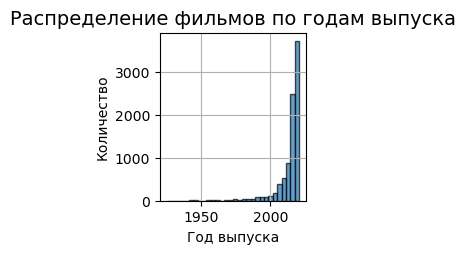

In [55]:
plt.subplot(2, 3, 1)
db['release_year'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Распределение фильмов по годам выпуска', fontsize=14)
plt.xlabel('Год выпуска')
plt.ylabel('Количество')


Text(0.5, 1.0, 'Соотношение фильмов и сериалов')

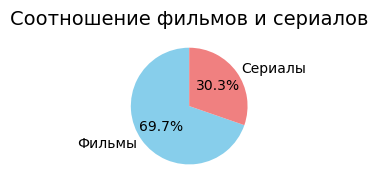

In [56]:
plt.subplot(2, 3, 2)
type_counts = db[['type_Movie', 'type_TV Show']].sum()
plt.pie(type_counts.values, labels=['Фильмы', 'Сериалы'], autopct='%1.1f%%', 
        colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Соотношение фильмов и сериалов', fontsize=14)

Text(0.5, 0, 'Количество')

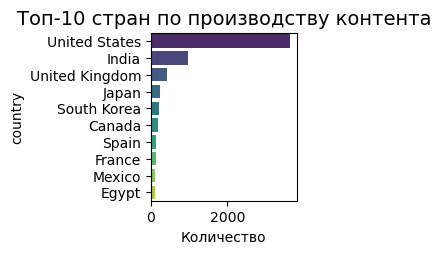

In [57]:
plt.subplot(2, 3, 3)
top_countries = db['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Топ-10 стран по производству контента', fontsize=14)
plt.xlabel('Количество')

In [58]:
numeric_cols = ['release_year', 'year_added', 'month_added', 'duration_numeric', 
                'rating_encoded', 'listed_in_encoded']

In [59]:
type_cols = [col for col in db.columns if col.startswith('type_')]
numeric_cols.extend(type_cols)

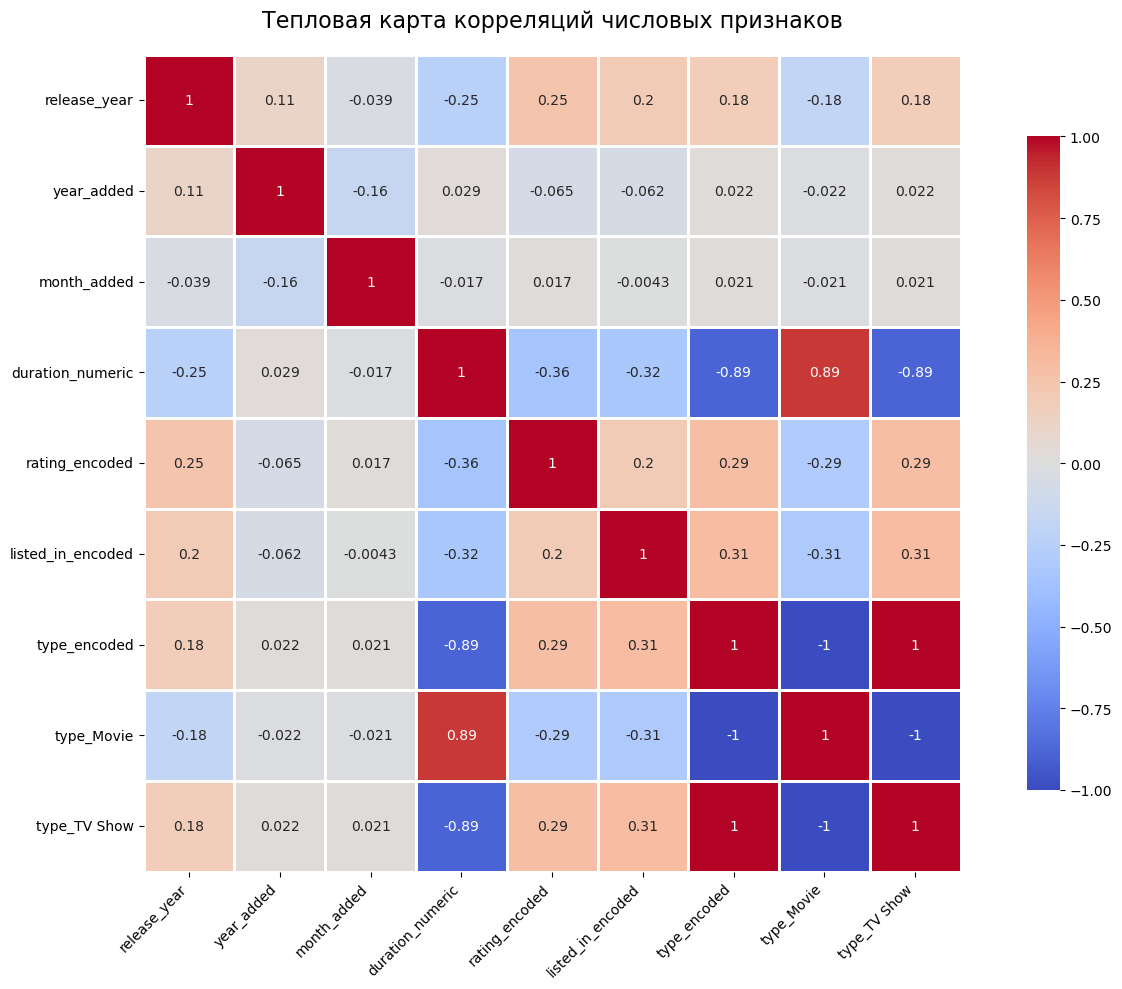

In [60]:
corr_matrix = db[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Тепловая карта корреляций числовых признаков', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Подготовка данных для обучения

In [61]:
feature_columns = ['release_year', 'year_added', 'month_added', 
                   'duration_numeric', 'rating_encoded', 'listed_in_encoded']

In [62]:
feature_columns.extend(type_cols)

In [63]:
db_ml = db.dropna(subset=['duration_numeric'])

In [64]:
X = db_ml[feature_columns]
y = db_ml['rating_encoded']

In [65]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [67]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (7032, 9)
Размер тестовой выборки: (1758, 9)


### Нейроная сеть

In [68]:
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

print("Обучение нейронной сети...")
nn_model.fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)
nn_accuracy = accuracy_score(y_test, nn_pred)

Обучение нейронной сети...


### Древо решений

In [69]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Обучение Random Forest...")
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

Обучение Random Forest...


In [70]:
print(f"Нейронная сеть (MLP) - Точность: {nn_accuracy:.4f}")
print(f"Random Forest - Точность: {rf_accuracy:.4f}")
print(f"Разница: {abs(nn_accuracy - rf_accuracy):.4f}")

Нейронная сеть (MLP) - Точность: 0.9989
Random Forest - Точность: 0.9954
Разница: 0.0034


### Ошибки моделей

(0.0, 1.0)

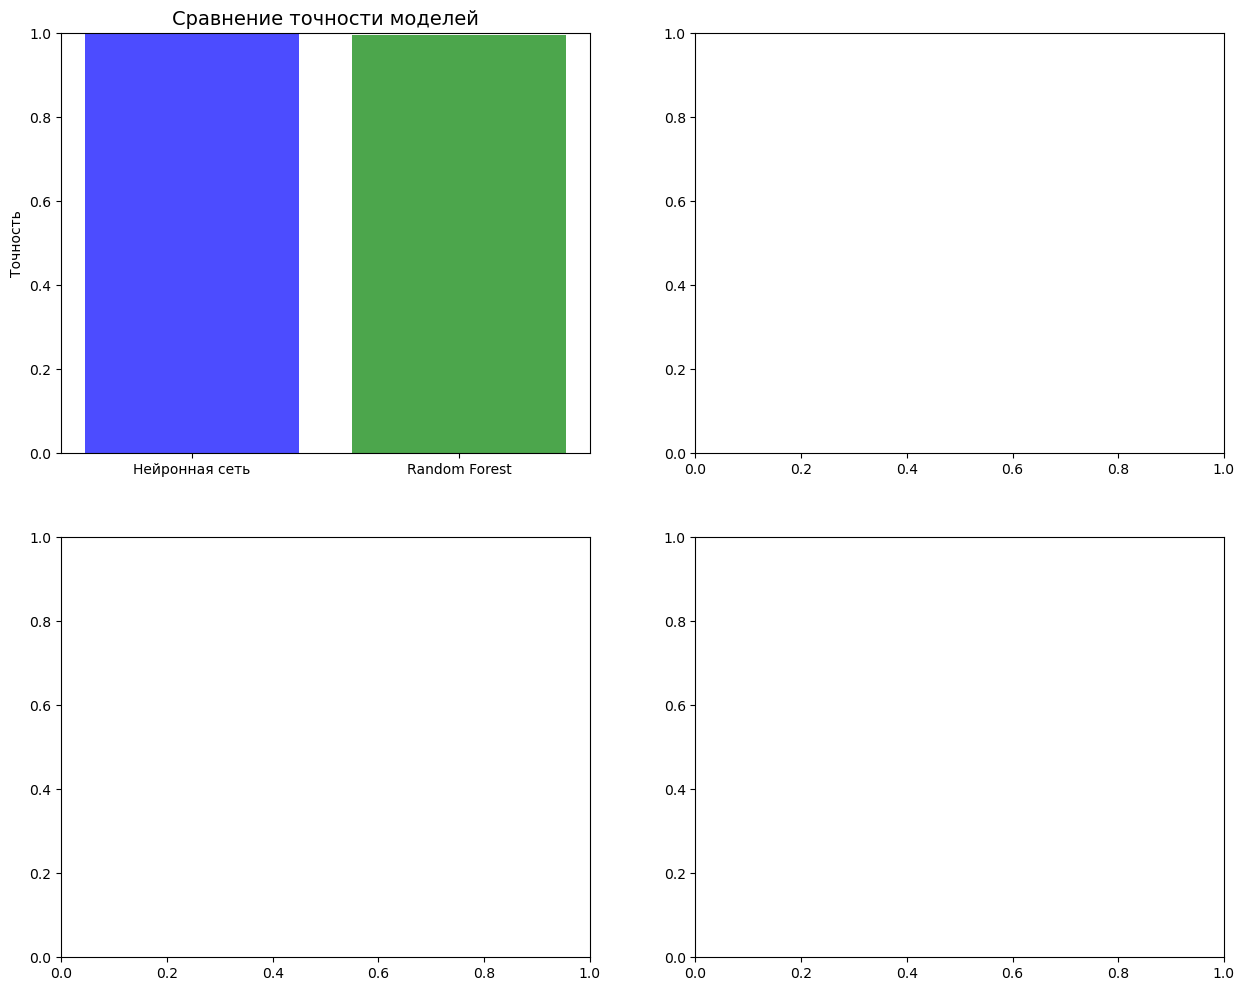

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Сравнение точности моделей
axes[0, 0].bar(['Нейронная сеть', 'Random Forest'], [nn_accuracy, rf_accuracy], 
               color=['blue', 'green'], alpha=0.7)
axes[0, 0].set_title('Сравнение точности моделей', fontsize=14)
axes[0, 0].set_ylabel('Точность')
axes[0, 0].set_ylim([0, 1])

In [76]:
cm_nn = confusion_matrix(y_test, nn_pred)
sns.heatmap(cm_nn[:10, :10], annot=True, fmt='d', ax=axes[0, 1], cmap='Blues')
axes[0, 1].set_title('Матрица ошибок (Нейронная сеть) - топ 10 классов', fontsize=14)
axes[0, 1].set_xlabel('Предсказано')
axes[0, 1].set_ylabel('Фактически')

Text(792.3131313131312, 0.5, 'Фактически')

In [77]:
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf[:10, :10], annot=True, fmt='d', ax=axes[1, 0], cmap='Greens')
axes[1, 0].set_title('Матрица ошибок (Random Forest) - топ 10 классов', fontsize=14)
axes[1, 0].set_xlabel('Предсказано')
axes[1, 0].set_ylabel('Фактически')

Text(158.22222222222223, 0.5, 'Фактически')

# ВЫВОД

#### Что сделали:

1. Провели очистку и нормализацию данных Netflix (обработали пропуски, преобразовали даты, закодировали категориальные признаки)

2. Обучили две модели машинного обучения для предсказания возрастного рейтинга контента:

3. Нейронная сеть (MLPClassifier с архитектурой 100-50-25 нейронов)

4. Случайный лес (RandomForestClassifier со 100 деревьями)

Результаты:

- Нейронная сеть: точность 99.89%

- Random Forest: точность 99.54%

- Разница между моделями: всего 0.35%

Итог: Обе модели можно использовать на практике, но если выбирать лучшую — это нейронная сеть с точностью 99.89%.